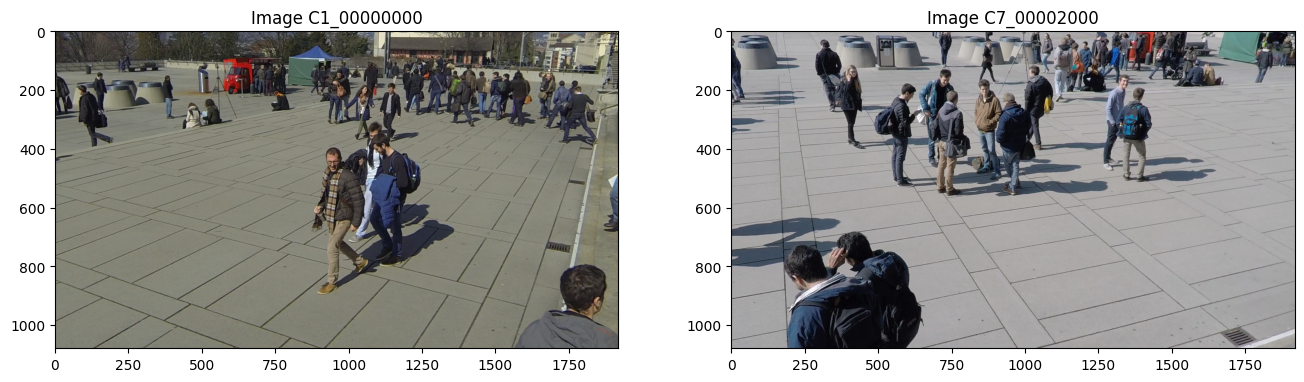

In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

C1_00000000 = read_image("/root/autodl-tmp/project/documents/datasets/Wildtrack2/ds/img/C1_00000000.png")
C7_00002000 = read_image("/root/autodl-tmp/project/documents/datasets/Wildtrack2/ds/img/C7_00002000.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image C1_00000000")
plt.imshow(C1_00000000.permute(1, 2, 0))
plt.subplot(122)
plt.title("Image C7_00002000")
plt.imshow(C7_00002000.permute(1, 2, 0))

In [5]:
import os
import json
import torch
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class WildtrackDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # 获取img和ann目录
        self.img_dir = os.path.join(root, "ds", "img")
        self.ann_dir = os.path.join(root, "ds", "ann")
        # 获取所有图像文件名并排序
        self.imgs = list(sorted(os.listdir(self.img_dir)))

    def __getitem__(self, idx):
        # 加载图像
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        img = read_image(img_path)
        
        # 加载对应的标注文件
        ann_path = os.path.join(self.ann_dir, self.imgs[idx] + ".json")
        with open(ann_path, 'r') as f:
            ann_data = json.load(f)
        
        # 提取所有行人目标的边界框和标签
        boxes = []
        person_ids = []
        position_ids = []
        
        for obj in ann_data['objects']:
            if obj['classTitle'] == 'pedestrian':
                # 获取边界框坐标
                exterior = obj['points']['exterior']
                boxes.append([
                    exterior[0][0],  # xmin
                    exterior[0][1],  # ymin
                    exterior[1][0],  # xmax
                    exterior[1][1]   # ymax
                ])
                
                # 获取person_id和position_id
                for tag in obj['tags']:
                    if tag['name'] == 'person id':
                        person_ids.append(tag['value'])
                    elif tag['name'] == 'position id':
                        position_ids.append(tag['value'])

        # 转换为tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        num_objs = len(boxes)
        
        # 所有目标都是行人类别(label=1)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        # 计算边界框面积
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # 假设所有实例都不是crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        # 将person_id和position_id转换为tensor
        person_ids = torch.as_tensor(person_ids, dtype=torch.int64)
        position_ids = torch.as_tensor(position_ids, dtype=torch.int64)

        # 构建target字典
        img = tv_tensors.Image(img)
        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img)),
            "labels": labels,
            "image_id": idx,
            "area": area,
            "iscrowd": iscrowd,
            "person_ids": person_ids,
            "position_ids": position_ids
        }

        # 应用transforms
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

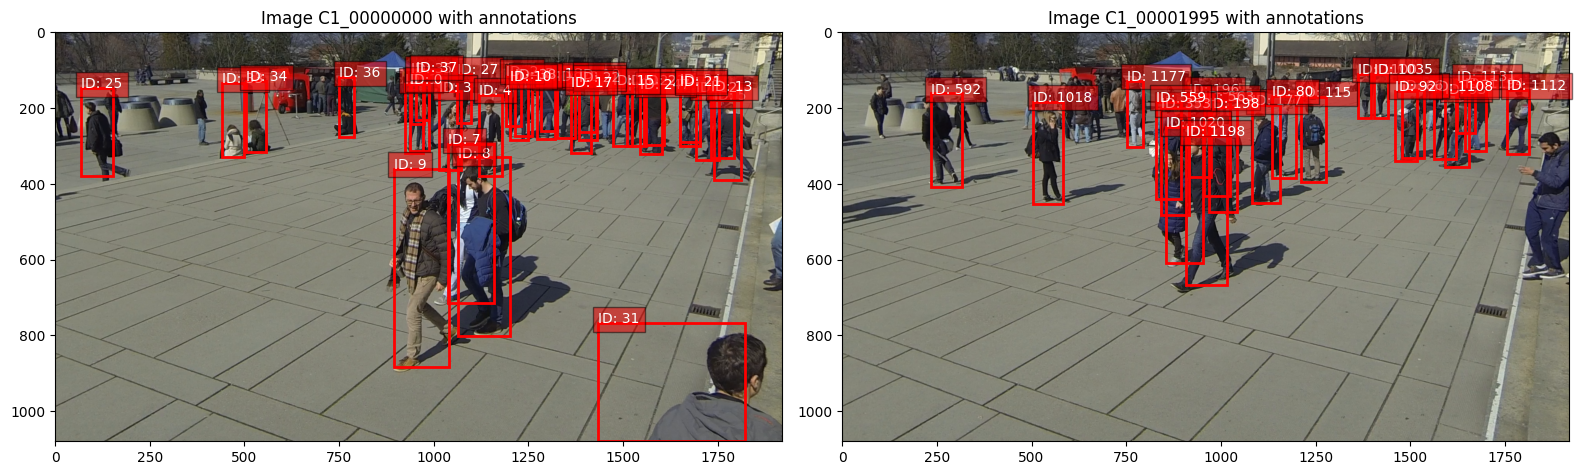

Image 1 contains 33 pedestrians
Image 2 contains 22 pedestrians


In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 实例化数据集
dataset = WildtrackDataset(root="/root/autodl-tmp/project/documents/datasets/Wildtrack2")

# 获取两张图片的索引
idx_c1 = dataset.imgs.index("C1_00000000.png")
idx_c7 = dataset.imgs.index("C1_00001995.png")

# 获取图像和标注信息
img1, target1 = dataset[idx_c1]
img2, target2 = dataset[idx_c7]

# 创建图像显示
plt.figure(figsize=(16, 8))

# 显示第一张图片及其标注
plt.subplot(121)
plt.title("Image C1_00000000 with annotations")
plt.imshow(img1.permute(1, 2, 0))
ax1 = plt.gca()
for box, person_id in zip(target1['boxes'], target1['person_ids']):
    x, y, x2, y2 = box.numpy()
    width = x2 - x
    height = y2 - y
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)
    plt.text(x, y, f'ID: {person_id.item()}', color='white', bbox=dict(facecolor='red', alpha=0.5))

# 显示第二张图片及其标注
plt.subplot(122)
plt.title("Image C1_00001995 with annotations")
plt.imshow(img2.permute(1, 2, 0))
ax2 = plt.gca()
for box, person_id in zip(target2['boxes'], target2['person_ids']):
    x, y, x2, y2 = box.numpy()
    width = x2 - x
    height = y2 - y
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax2.add_patch(rect)
    plt.text(x, y, f'ID: {person_id.item()}', color='white', bbox=dict(facecolor='red', alpha=0.5))

plt.tight_layout()
plt.show()

# 打印一些统计信息
print(f"Image 1 contains {len(target1['boxes'])} pedestrians")
print(f"Image 2 contains {len(target2['boxes'])} pedestrians")


Testing `forward()` method (Optional)
=====================================

Before iterating over the dataset, it\'s good to see what the model
expects during training and inference time on sample data.


In [7]:
def get_transform(train):
    from torchvision.transforms import v2 as T
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [14]:
import torchvision
import utils
from torchvision.models.detection import *
from torchvision.transforms import v2 as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from datasets.wildtrack2_datasets import WildtrackDataset

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

# 初始化模型（分两步）
# 1. 先加载预训练模型
model_finetuning = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
# 2. 替换分类器头部
in_features = model_finetuning.roi_heads.box_predictor.cls_score.in_features
model_finetuning.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

# 加载数据集
dataset = WildtrackDataset(
    root="/root/autodl-tmp/project/documents/datasets/Wildtrack2", 
    transforms=get_transform(train=True)
)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# 训练模式测试
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model_finetuning(images, targets)  # 返回损失和检测结果
print("Training mode output (losses):", output)

# 推理模式测试
model_finetuning.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model_finetuning(x)  # 返回预测结果
print("Inference mode output (predictions):", predictions[0])

Training mode output (losses): {'loss_classifier': tensor(0.6242, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.6819, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.2678, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1153, grad_fn=<DivBackward0>)}
Inference mode output (predictions): {'boxes': tensor([[111.7057,  67.0599, 116.4789,  71.5536],
        [113.3439,  65.3170, 117.5003,  69.8617],
        [323.2171,  65.8332, 327.1871,  69.5947],
        [ 86.1132,  63.2371,  90.7530,  69.0203],
        [323.3020,  64.3526, 327.1901,  67.9711],
        [173.4459,  61.9488, 177.0034,  65.3554],
        [103.7632,  64.2273, 108.4392,  69.4208],
        [325.2505,  64.7432, 328.7340,  68.2189],
        [325.1032,  65.9985, 328.6258,  69.6918],
        [112.0976,  60.8519, 116.0088,  65.3300],
        [170.2343,  62.3649, 173.9416,  66.0116],
        [110.3893,  61.5614, 114.3933,  66.6119],
        [ 87.5270,  59.6154,  91.8622,  65.4222],
        

Let's now write the main function which performs the training and the
validation, then test the model on the test set:

In [16]:
import os
import torch
import utils
import numpy as np
import torchvision
import utils
from torchvision.models.detection import *
from torchvision.transforms import v2 as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from datasets.wildtrack2_datasets import WildtrackDataset
from engine import train_one_epoch, evaluate

# 创建动态目录
base_name = 'model'
counter = 0
dir_name = base_name
while os.path.exists(dir_name):
    counter += 1
    dir_name = f"{base_name}_{counter}"
target_dir = os.path.join(dir_name, 'checkpoints')
os.makedirs(target_dir, exist_ok=True)
print(f"Created directory: {target_dir}")

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

def save_checkpoint(model, optimizer, lr_scheduler, epoch, mAP, target_dir, is_best=False):
    """保存检查点和最佳模型"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler_state_dict': lr_scheduler.state_dict(),
        'map': mAP
    }
    
    checkpoint_name = f'checkpoint_epoch_{epoch}_map_{mAP:.4f}.pth'
    checkpoint_path = os.path.join(target_dir, checkpoint_name)
    torch.save(checkpoint, checkpoint_path)
    print(f'Saved checkpoint: {checkpoint_name}')
    
    if is_best:
        best_path = os.path.join(dir_name, 'best.pth')
        torch.save(checkpoint, best_path)
        print(f'New best model saved with mAP: {mAP:.4f}')
    
    return checkpoint_path

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 创建完整数据集
dataset = WildtrackDataset(
    root="/root/autodl-tmp/project/documents/datasets/Wildtrack2", 
    transforms=None
)

# 按80-10-10比例划分数据集
total_size = len(dataset)
indices = torch.randperm(total_size).tolist()

train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

class TransformSubset(torch.utils.data.Subset):
    def __init__(self, dataset, indices, transform=None):
        super().__init__(dataset, indices)
        self.transform = transform

    def __getitem__(self, idx):
        img, target = self.dataset[self.indices[idx]]
        if self.transform is not None:
            img = self.transform(img)  # 只对图像进行转换，不处理target
            
        # 添加调试信息
        if isinstance(img, torch.Tensor):
            print(f"Image tensor - dtype: {img.dtype}, shape: {img.shape}, range: [{img.min():.3f}, {img.max():.3f}]")
            
        return img, target

# 创建训练、验证和测试数据集
train_dataset = TransformSubset(dataset, train_indices, transform=get_transform(train=True))
val_dataset = TransformSubset(dataset, val_indices, transform=get_transform(train=False))
test_dataset = TransformSubset(dataset, test_indices, transform=get_transform(train=False))

# 创建数据加载器
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True,
    collate_fn=utils.collate_fn, num_workers=0, pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False,
    collate_fn=utils.collate_fn, num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False,
    collate_fn=utils.collate_fn, num_workers=4
)

# 将模型移动到设备
# 初始化模型（分两步）
# 1. 先加载预训练模型
model_finetuning = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
# 2. 替换分类器头部
in_features = model_finetuning.roi_heads.box_predictor.cls_score.in_features
model_finetuning.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
model_finetuning = model_finetuning.to(device)

# 优化器设置（微调时使用较小的学习率）
params = [p for p in model_finetuning.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 训练参数
num_epochs = 30
patience = 10
best_map = 0.0
no_improve_epochs = 0
saved_checkpoints = []

# 训练循环
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch}/{num_epochs-1}')
    print('-' * 10)
    
    # 训练一个epoch
    train_one_epoch(model_finetuning, optimizer, train_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    
    # 在验证集上评估
    print("Evaluating on validation set...")
    coco_evaluator = evaluate(model_finetuning, val_loader, device=device)
    current_map = coco_evaluator.coco_eval['bbox'].stats[0]
    print(f'Validation mAP: {current_map:.4f}')
    
    # 检查是否是最佳模型
    is_best = current_map > best_map
    if is_best:
        best_map = current_map
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
    
    # 保存检查点
    checkpoint_path = save_checkpoint(
        model_finetuning, optimizer, lr_scheduler, 
        epoch, current_map, target_dir, is_best
    )
    saved_checkpoints.append(checkpoint_path)
    
    # 只保留最近5个检查点
    if len(saved_checkpoints) > 5:
        old_path = saved_checkpoints.pop(0)
        if os.path.exists(old_path):
            os.remove(old_path)
    
    # 检查早停条件
    if no_improve_epochs >= patience:
        print(f'\nEarly stopping triggered after {patience} epochs without improvement')
        break

# 加载最佳模型进行最终测试
print('\nLoading best model for final evaluation...')
best_model_path = os.path.join(dir_name, 'best.pth')
checkpoint = torch.load(best_model_path)
model_finetuning.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model was from epoch {checkpoint['epoch']} with mAP {checkpoint['map']:.4f}")

# 在测试集上进行最终评估
print('\nEvaluating on test set...')
final_evaluator = evaluate(model_finetuning, test_loader, device=device)
final_map = final_evaluator.coco_eval['bbox'].stats[0]
print(f'Final Test mAP: {final_map:.4f}')
print('--------------------------------------------------')

Created directory: model_2/checkpoints
Using device: cuda



Epoch 0/29
----------


TypeError: Expected input images to be of floating type (in range [0, 1]), but found type torch.uint8 instead